# Solar Power Forecasting Using Vector Auto Regression

1. Read labeled data from output.xlsx
2. Set forecast_days
3. Generate probabilistic labels
4. Run VAR

In [95]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [96]:
#run mark

In [97]:
forecast_days = 10

In [98]:
xls = pd.ExcelFile("output.xlsx")

In [99]:
years = ["2012","2013","2014","2015","2016","2017","2018","2019","2020"]

In [100]:
df_obj = dict()
for i in years:
    df_obj[i] = pd.read_excel(xls, i)
    df_obj[i] = df_obj[i].drop(["Unnamed: 0"],axis=True)

In [101]:
df_obj

{'2012':           Date  1104500527  1104500529  1.104501e+09  7802195.0  \
 0   2012-07-06         679         825           837      869.0   
 1   2012-07-07         882         899           910      924.0   
 2   2012-07-08        1051        1080          1091     1129.0   
 3   2012-07-09        1114        1136          1148     1172.0   
 4   2012-07-10         153         159           170      162.0   
 ..         ...         ...         ...           ...        ...   
 174 2012-12-27        1199        1217          1187     1149.0   
 175 2012-12-28        1147        1182          1125     1054.0   
 176 2012-12-29        1074        1125          1057     1021.0   
 177 2012-12-30        1029        1068          1007      973.0   
 178 2012-12-31        1035        1080          1012      984.0   
 
     2100570073/ 2100567820/ 2100567898  Total Generation (KWH)  \
 0                                    8                 3218.00   
 1                                   18 

## Forecasting start

In [102]:
df_obj['2015'].columns

Index(['Date', '1104500527', '1104500529', '1.104501e+09', '7802195.0',
       '2100570073/ 2100567820/ 2100567898', 'Total Generation (KWH)',
       'Aggregate Meter Reading (KWH)', 'Difference', 'SEEDs data (KWH)',
       'Insolation', 'PR (%)', 'Any Issues/Problems Observed', 'WO#',
       'NO-OFF-CLEAN MODULES', 'Grid Failure', 'Inverter', 'Module Cleaning',
       'Rainy day', 'No Module Cleaning',
       'Transformer replacement and maintenance', 'Cable and Fuse maintenance',
       'Plant Shutdown', 'Internet', 'Battery', 'Cloudy',
       'Module Cleaning by rains'],
      dtype='object')

In [103]:
df_jun = df_obj['2019']
# df = df.append(df_obj['2016'])
#for i in range(2013, 2019):
    #df_jun = df_jun.append(df_obj[str(i)])

df1_jun = df_jun.drop([
    "1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898",
    "Aggregate Meter Reading (KWH)",
    "Difference", "SEEDs data (KWH)",
    "PR (%)", "Any Issues/Problems Observed", "WO#"], axis=1)
df1_jun['Insolation'] = df1_jun['Insolation'].fillna(df1_jun['Insolation'].mean())
# df1 = df1.fillna(0)
df1_jun['NO-OFF-CLEAN MODULES'] = df1_jun['NO-OFF-CLEAN MODULES'].replace(
    r'^\s*$', np.nan, regex=True)
df1_jun['NO-OFF-CLEAN MODULES'] = df1_jun['NO-OFF-CLEAN MODULES'].fillna(0)
df1_jun['NO-OFF-CLEAN MODULES'] = pd.to_numeric(
    df1_jun['NO-OFF-CLEAN MODULES'])
df1_jun['Date'] = pd.to_datetime(df1_jun['Date'])
df1_jun = df1_jun.set_index('Date')
df1_jun = df1_jun[:'2019-05-31']
df1_jun


,Total Generation (KWH),Insolation,NO-OFF-CLEAN MODULES,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
Date,,,,,,,,,,,,,,,
2019-01-01,3812.94,5.357,524.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-02,3920.74,5.380,441.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-03,4113.45,5.598,903.0,1,0,1,0,0,0,0,0,0,0,0,0
2019-01-04,3873.59,5.136,1281.0,0,0,1,0,0,0,0,0,0,0,0,0
2019-01-05,3603.61,4.808,792.0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,4228.21,6.336,0.0,1,0,0,0,0,0,0,0,0,0,0,0
2019-05-28,4244.22,6.303,0.0,1,0,0,0,0,0,0,0,0,0,0,0
2019-05-29,4291.19,6.287,0.0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
df = df_obj['2012']
# df = df.append(df_obj['2016'])
for i in range(2013,2019):
    df = df.append(df_obj[str(i)])
    
df1 = df.drop([
                    "1104500527", "1104500529", "1.104501e+09", "7802195.0", "2100570073/ 2100567820/ 2100567898", 
                    "Aggregate Meter Reading (KWH)", 
                    "Difference", "SEEDs data (KWH)",  
                    "PR (%)", "Any Issues/Problems Observed", "WO#"], axis=1)

C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_24236\2648422872.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_24236\2648422872.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_24236\2648422872.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_24236\2648422872.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_obj[str(i)])
C:\Users\Rajeshsingh\AppData\Local\Temp\ipyk

In [105]:
df1['Insolation'] = df1['Insolation'].fillna(df1['Insolation'].mean())
# df1 = df1.fillna(0)

In [106]:
df1['NO-OFF-CLEAN MODULES'] = df1['NO-OFF-CLEAN MODULES'].replace(r'^\s*$', np.nan, regex=True)
df1['NO-OFF-CLEAN MODULES'] = df1['NO-OFF-CLEAN MODULES'].fillna(0)

In [107]:
df1['NO-OFF-CLEAN MODULES'] = pd.to_numeric(df1['NO-OFF-CLEAN MODULES'])

In [108]:
df1

,Date,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
0,2012-07-06,3218.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1,2012-07-07,3633.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2,2012-07-08,4377.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
3,2012-07-09,4625.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
4,2012-07-10,648.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,4129.29,5.74700,1,0,1,0,0,0,0,0,0,0,0,0,971.0
361,2018-12-28,4266.50,5.68900,0,0,1,0,0,0,0,0,0,0,0,0,0.0
362,2018-12-29,3732.03,5.83400,1,0,1,0,0,0,0,0,0,0,0,0,720.0
363,2018-12-30,4063.88,5.58400,0,1,0,0,0,0,0,0,0,0,0,0,0.0


In [109]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [110]:
df1 = df1.set_index('Date')

In [111]:
df1

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Date,,,,,,,,,,,,,,,
2012-07-06,3218.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-07,3633.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-08,4377.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-09,4625.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-10,648.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,4129.29,5.74700,1,0,1,0,0,0,0,0,0,0,0,0,971.0
2018-12-28,4266.50,5.68900,0,0,1,0,0,0,0,0,0,0,0,0,0.0
2018-12-29,3732.03,5.83400,1,0,1,0,0,0,0,0,0,0,0,0,720.0


In [112]:
# for i in df1.columns[1:]:
#     print(i)
#     temp = df1[i].value_counts().to_dict()
#     print(temp)
#     if 1.0 in temp.keys():
#         df1[str(i)][df1[str(i)] == 1.0] = (temp[1.0]/100)**12

In [113]:
df_till_jun = df1.append(df1_jun)
#df_till_jun = pd.concat([df1, df1_jun], axis=0)
df_till_jun

C:\Users\Rajeshsingh\AppData\Local\Temp\ipykernel_24236\2041396177.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_till_jun = df1.append(df1_jun)


,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Date,,,,,,,,,,,,,,,
2012-07-06,3218.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-07,3633.00,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-08,4377.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-09,4625.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-10,648.00,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-27,4228.21,6.33600,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2019-05-28,4244.22,6.30300,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2019-05-29,4291.19,6.28700,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [114]:
df1.head()

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Date,,,,,,,,,,,,,,,
2012-07-06,3218.0,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-07,3633.0,9.37536,1,0,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-08,4377.0,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-09,4625.0,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0
2012-07-10,648.0,9.37536,0,1,0,0,0,0,0,0,0,0,0,0,0.0


In [115]:
df1['Total Generation (KWH)'] = pd.to_numeric(df1['Total Generation (KWH)'])
df1['Total Generation (KWH)'].dtype

dtype('float64')

In [116]:
corr_df = df1.corr()
# corr_df[corr_df < 0] = 0
corr_df

,Total Generation (KWH),Insolation,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains,NO-OFF-CLEAN MODULES
Total Generation (KWH),1.000000,-0.024524,-0.130600,-0.314601,0.128121,-0.243720,-0.005216,-0.050500,0.032419,0.014604,0.058770,-0.042502,-0.430203,NaN,-0.009910
Insolation,-0.024524,1.000000,-0.014171,0.003589,-0.019096,-0.007896,-0.005430,-0.002112,-0.005786,-0.000670,-0.001732,-0.003606,-0.010411,NaN,-0.000011
Grid Failure,-0.130600,-0.014171,1.000000,0.057966,0.028741,0.006965,-0.071054,-0.008649,-0.004769,0.027274,0.007146,-0.006409,-0.026162,NaN,0.027293
Inverter,-0.314601,0.003589,0.057966,1.000000,-0.240594,0.345086,-0.065587,0.047602,-0.057207,-0.006944,-0.045619,0.107890,0.170230,NaN,-0.007084
Module Cleaning,0.128121,-0.019096,0.028741,-0.240594,1.000000,-0.097901,-0.138123,0.046175,0.036938,0.028864,-0.103348,-0.076412,-0.206888,NaN,0.029442
Rainy day,-0.243720,-0.007896,0.006965,0.345086,-0.097901,1.000000,-0.026688,0.022688,-0.004281,-0.002826,-0.022166,-0.014764,0.304770,NaN,-0.002883
No Module Cleaning,-0.005216,-0.005430,-0.071054,-0.065587,-0.138123,-0.026688,1.000000,-0.017444,0.008297,-0.003987,-0.031273,-0.020830,0.032792,NaN,-0.004067
Transformer replacement and maintenance,-0.050500,-0.002112,-0.008649,0.047602,0.046175,0.022688,-0.017444,1.000000,-0.015215,-0.001847,-0.014488,-0.009650,-0.027950,NaN,-0.001812
Cable and Fuse maintenance,0.032419,-0.005786,-0.004769,-0.057207,0.036938,-0.004281,0.008297,-0.015215,1.000000,-0.003477,-0.027277,0.054323,-0.014822,NaN,-0.003460
Plant Shutdown,0.014604,-0.000670,0.027274,-0.006944,0.028864,-0.002826,-0.003987,-0.001847,-0.003477,1.000000,-0.003311,-0.002206,-0.009272,NaN,-0.000431


In [117]:
# total_0 = 0
# total_1 = 0
# for i in df1.columns[1:]:
#     value_c = df1[i].value_counts()
#     print(df1[i].value_counts())
#     total_0 += value_c[]

In [118]:
df1 = df1.drop(["Cable and Fuse maintenance","NO-OFF-CLEAN MODULES", "No Module Cleaning","Rainy day", "Insolation" ,"Transformer replacement and maintenance","Plant Shutdown","Internet","Battery","Module Cleaning by rains"], axis=1)
df1

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.00,1,0,0,0
2012-07-07,3633.00,1,0,0,0
2012-07-08,4377.00,0,1,0,0
2012-07-09,4625.00,0,1,0,0
2012-07-10,648.00,0,1,0,0
...,...,...,...,...,...
2018-12-27,4129.29,1,0,1,0
2018-12-28,4266.50,0,0,1,0
2018-12-29,3732.03,1,0,1,0


In [119]:
df1

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.00,1,0,0,0
2012-07-07,3633.00,1,0,0,0
2012-07-08,4377.00,0,1,0,0
2012-07-09,4625.00,0,1,0,0
2012-07-10,648.00,0,1,0,0
...,...,...,...,...,...
2018-12-27,4129.29,1,0,1,0
2018-12-28,4266.50,0,0,1,0
2018-12-29,3732.03,1,0,1,0


In [120]:
endog_array = df1.to_numpy(dtype=int)

In [121]:
var_model = VAR(endog_array)

In [122]:
var_model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,6.275,6.288,531.3,6.280
1,3.395,3.470,29.82,3.422
2,3.140,3.276,23.11,3.190
3,3.041,3.239,20.92,3.113
4,2.998,3.258,20.04,3.092
5,2.966,3.288,19.42,3.084
6,2.942,3.326,18.95,3.082
7,2.695,3.141*,14.81,2.858
8,2.647,3.154,14.11,2.832*
9,2.644,3.214,14.07,2.852


In [123]:
results = var_model.fit(15, trend='c', ic='aic')

In [124]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     18:07:47
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    3.51735
Nobs:                     2355.00    HQIC:                   2.92594
Log likelihood:          -19374.5    FPE:                    13.2944
AIC:                      2.58723    Det(Omega_mle):         11.3422
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        429.308862       103.472155            4.149           0.000
L1.y1          0.565818         0.021648           26.137           0.000
L1.y2         96.226095        31.150276            3.089           0.002
L1.y3        -94.

0.02164810016066973
0.024771498679911116
0.02483676245533024
0.024842935667163158
0.0248584212876696
0.024940387629293344
0.02494226924866736
0.024933831372270225
0.024951523287980323
0.024992567812099617
0.02485617123743019
0.024763893249157936
0.02479101675738902
0.024788014767129753
0.021828458838513212


Text(0, 0.5, 'std. error')

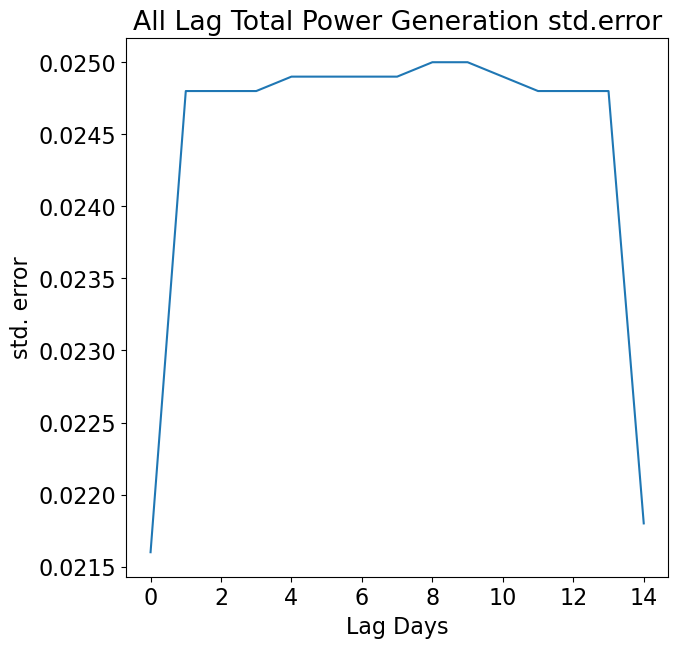

In [125]:
stderr_value = list(results.stderr)[1:]
error_value = []
for i in range(75):
    if i % 5 == 0:
        print(stderr_value[i][0])
        error_value.append(round(stderr_value[i][0],4))
fig = plt.figure(figsize=(7,7))
plt.plot(error_value)    
plt.title("All Lag Total Power Generation std.error")
plt.xlabel('Lag Days')
plt.ylabel('std. error')

In [126]:
# fig.savefig('std_error')

In [127]:
for i in list(results.stderr):
    for j in i:
        print(round(j,3))

103.472
0.071
0.033
0.041
0.027
0.022
0.0
0.0
0.0
0.0
31.15
0.021
0.01
0.012
0.008
67.859
0.046
0.022
0.027
0.018
54.294
0.037
0.017
0.022
0.014
81.286
0.055
0.026
0.032
0.021
0.025
0.0
0.0
0.0
0.0
31.341
0.021
0.01
0.013
0.008
70.966
0.048
0.023
0.028
0.019
55.56
0.038
0.018
0.022
0.015
90.551
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.38
0.021
0.01
0.013
0.008
71.634
0.049
0.023
0.029
0.019
55.851
0.038
0.018
0.022
0.015
91.038
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.297
0.021
0.01
0.012
0.008
71.63
0.049
0.023
0.029
0.019
56.242
0.038
0.018
0.022
0.015
91.411
0.062
0.029
0.036
0.024
0.025
0.0
0.0
0.0
0.0
31.287
0.021
0.01
0.012
0.008
71.512
0.049
0.023
0.029
0.019
56.265
0.038
0.018
0.022
0.015
91.623
0.063
0.029
0.037
0.024
0.025
0.0
0.0
0.0
0.0
31.241
0.021
0.01
0.012
0.008
71.31
0.049
0.023
0.028
0.019
56.203
0.038
0.018
0.022
0.015
91.539
0.062
0.029
0.037
0.024
0.025
0.0
0.0
0.0
0.0
31.192
0.021
0.01
0.012
0.008
71.222
0.049
0.023
0.028
0.019
56.133
0.038
0.018
0

In [128]:
for index, i in enumerate(list(results.stderr)):
    print(index, i)

0 [1.03472155e+02 7.06148308e-02 3.31345858e-02 4.12717604e-02
 2.73032639e-02]
1 [2.16481002e-02 1.47738001e-05 6.93230784e-06 8.63474047e-06
 5.71229808e-06]
2 [3.11502756e+01 2.12585835e-02 9.97516172e-03 1.24248569e-02
 8.21964322e-03]
3 [6.78586017e+01 4.63102724e-02 2.17301617e-02 2.70666437e-02
 1.79058928e-02]
4 [5.42935245e+01 3.70527515e-02 1.73862567e-02 2.16559647e-02
 1.43264671e-02]
5 [8.12858784e+01 5.54737509e-02 2.60299392e-02 3.24223584e-02
 2.14489569e-02]
6 [2.47714987e-02 1.69053712e-05 7.93250462e-06 9.88056506e-06
 6.53647125e-06]
7 [3.13406321e+01 2.13884927e-02 1.00361190e-02 1.25007840e-02
 8.26987271e-03]
8 [7.09658945e+01 4.84308521e-02 2.27252010e-02 2.83060442e-02
 1.87258161e-02]
9 [5.55600045e+01 3.79170640e-02 1.77918178e-02 2.21611234e-02
 1.46606540e-02]
10 [9.05509670e+01 6.17967338e-02 2.89968715e-02 3.61179084e-02
 2.38937418e-02]
11 [2.48367625e-02 1.69499106e-05 7.95340385e-06 9.90659671e-06
 6.55369244e-06]
12 [3.13803323e+01 2.14155862e-02 1.00

In [129]:
lag = results.k_ar

In [130]:
forecast_results = results.forecast(df1.values[-lag:],steps=forecast_days)

## Results

In [131]:
forecast_power = []
# insolation_pred = []
grid_pred = []
inverter_pred = []
module_pred = []
module_no_pred= []
cloudy_pred = []
for i in forecast_results:
    forecast_power.append(i[0])
#     insolation_pred.append(i[1])
    grid_pred.append(i[1])
    inverter_pred.append(i[2])
    module_pred.append(i[3])
#     module_no_pred.append(i[5])
    cloudy_pred.append(i[4])

In [132]:
forecast_list_dict = dict()
for col in df1.columns:
    forecast_list_dict[col] = []
for i in forecast_results:
    for j, col_name in zip(range(len(i)), df1.columns):
        forecast_list_dict[col_name].append(i[j]) 

In [133]:
# forecast_list_dict

In [134]:
power_16 = df_obj['2019']['Total Generation (KWH)']
diff_power = pd.DataFrame({"Prediction":forecast_power[:forecast_days],"Original":power_16[:forecast_days],
#                            "Insolation_pred" : insolation_pred[:forecast_days],
                           "Grid_pred":grid_pred[:forecast_days],
                          "Module_pred":module_pred[:forecast_days],
                            "Cloudy_pred":cloudy_pred[:forecast_days],
                          "Inverter_pred":inverter_pred[:forecast_days],
#                            "NO-OFF-CLEAN MODULES" : module_no_pred[:forecast_days]
                          })
diff_power['Difference'] = diff_power['Prediction'] - diff_power['Original']
diff_power

,Prediction,Original,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred,Difference
0,4006.415791,3812.94,0.487502,0.919024,0.013340,0.134071,193.475791
1,4018.499292,3920.74,0.421920,0.938666,-0.020539,0.074634,97.759292
2,4176.960999,4113.45,0.411235,0.924108,-0.006022,0.113328,63.510999
3,4119.503935,3873.59,0.372910,0.883409,-0.001627,0.104822,245.913935
4,3921.924689,3603.61,0.558229,0.943164,0.006326,0.079327,318.314689
5,3916.175485,4401.37,0.394121,0.269509,0.027434,0.299704,-485.194515
6,3903.286758,3852.56,0.548953,0.986328,0.034072,0.063813,50.726758
7,3875.556369,3913.55,0.456653,0.823999,0.074195,0.145397,-37.993631
8,4044.455014,3731.08,0.339145,0.835986,0.033584,0.128262,313.375014
9,3992.133402,4058.75,0.376363,0.850405,0.043758,0.084118,-66.616598


## Plot results

In [135]:
date_list = pd.date_range(start="2019-01-01",end="2019-12-31")
date_list = pd.to_datetime(date_list)
diff_power['Date'] = date_list[:forecast_days]

In [136]:
diff_power

,Prediction,Original,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred,Difference,Date
0,4006.415791,3812.94,0.487502,0.919024,0.013340,0.134071,193.475791,2019-01-01
1,4018.499292,3920.74,0.421920,0.938666,-0.020539,0.074634,97.759292,2019-01-02
2,4176.960999,4113.45,0.411235,0.924108,-0.006022,0.113328,63.510999,2019-01-03
3,4119.503935,3873.59,0.372910,0.883409,-0.001627,0.104822,245.913935,2019-01-04
4,3921.924689,3603.61,0.558229,0.943164,0.006326,0.079327,318.314689,2019-01-05
5,3916.175485,4401.37,0.394121,0.269509,0.027434,0.299704,-485.194515,2019-01-06
6,3903.286758,3852.56,0.548953,0.986328,0.034072,0.063813,50.726758,2019-01-07
7,3875.556369,3913.55,0.456653,0.823999,0.074195,0.145397,-37.993631,2019-01-08
8,4044.455014,3731.08,0.339145,0.835986,0.033584,0.128262,313.375014,2019-01-09
9,3992.133402,4058.75,0.376363,0.850405,0.043758,0.084118,-66.616598,2019-01-10


In [137]:
rmse = mean_squared_error(power_16[:forecast_days],forecast_power)**(1/2)
rmse

235.56175830267725

In [138]:
mae = mean_absolute_error(power_16[:forecast_days],forecast_power)
mae

187.28812211818436

In [139]:
rmspe = round(np.sqrt(np.mean(np.square(((power_16[:forecast_days] - forecast_power) / power_16[:forecast_days])), axis=0))*100,3)
rmspe

5.917

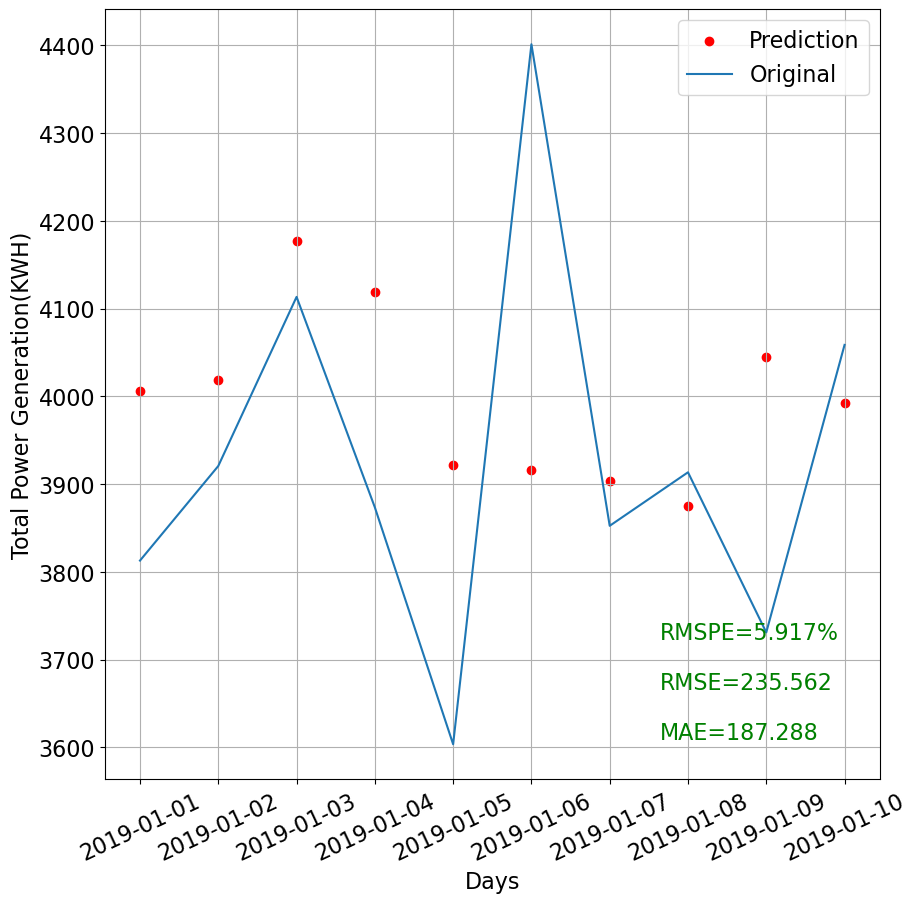

In [140]:
fig = plt.figure(figsize=(10,10))
font = {'size': 16}
plt.rc('font', **font)
plt.scatter('Date', 'Prediction', data=diff_power, label='Prediction', c='r')
plt.plot('Date', 'Original', data=diff_power, label='Original')
plt.legend()
plt.figtext(.68, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.figtext(.68, .2, "RMSE="+str(round(rmse, 3)), c='g')
plt.figtext(.68, .15, "MAE="+str(round(mae, 3)), c='g')
plt.xticks(rotation=25)
plt.grid()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.show()
# plt.title(str(forecast_days)+'_Days Prediction_for_Binary_Var', fontsize=30)

In [141]:
fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_Binary', dpi=500)

## Regression conversion

In [142]:
# new_diff_power = 

## Fetching results

In [143]:
# writer = pd.ExcelWriter('12_days.xlsx',engine='xlsxwriter')

In [144]:
# diff_power.to_excel(writer, sheet_name='12_days')

In [145]:
# writer.save()
# writer.close()

## Check the result with regressor

In [146]:
from sklearn.ensemble import RandomForestRegressor

In [147]:
df1.head()

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2012-07-06,3218.0,1,0,0,0
2012-07-07,3633.0,1,0,0,0
2012-07-08,4377.0,0,1,0,0
2012-07-09,4625.0,0,1,0,0
2012-07-10,648.0,0,1,0,0


In [148]:
df1.tail()

,Total Generation (KWH),Grid Failure,Inverter,Module Cleaning,Cloudy
Date,,,,,
2018-12-27,4129.29,1,0,1,0
2018-12-28,4266.50,0,0,1,0
2018-12-29,3732.03,1,0,1,0
2018-12-30,4063.88,0,1,0,0
2018-12-31,4093.90,1,0,1,0


In [149]:
X_train = df1.drop(["Total Generation (KWH)"], axis=1)
Y_train = df1['Total Generation (KWH)']
X_test = diff_power.drop(["Prediction","Original","Difference","Date"], axis=1)

In [150]:
X_test

,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred
0,0.487502,0.919024,0.013340,0.134071
1,0.421920,0.938666,-0.020539,0.074634
2,0.411235,0.924108,-0.006022,0.113328
3,0.372910,0.883409,-0.001627,0.104822
4,0.558229,0.943164,0.006326,0.079327
5,0.394121,0.269509,0.027434,0.299704
6,0.548953,0.986328,0.034072,0.063813
7,0.456653,0.823999,0.074195,0.145397
8,0.339145,0.835986,0.033584,0.128262
9,0.376363,0.850405,0.043758,0.084118


In [151]:
Y_test = diff_power['Original']

In [152]:
X_test

,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred
0,0.487502,0.919024,0.013340,0.134071
1,0.421920,0.938666,-0.020539,0.074634
2,0.411235,0.924108,-0.006022,0.113328
3,0.372910,0.883409,-0.001627,0.104822
4,0.558229,0.943164,0.006326,0.079327
5,0.394121,0.269509,0.027434,0.299704
6,0.548953,0.986328,0.034072,0.063813
7,0.456653,0.823999,0.074195,0.145397
8,0.339145,0.835986,0.033584,0.128262
9,0.376363,0.850405,0.043758,0.084118


In [153]:
from sklearn.model_selection import GridSearchCV

In [154]:
regr = RandomForestRegressor(max_depth=100, random_state=42)
regr.fit(X_train,Y_train)
Y_predrand = regr.predict(X_test)
print(mean_squared_error(Y_test, Y_predrand)**(1/2))
# print(r2_score(Y_test, Y_predrand))

555.7650390589063


c:\Users\Rajeshsingh\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Cloudy_pred
- Grid_pred
- Inverter_pred
- Module_pred
Feature names seen at fit time, yet now missing:
- Cloudy
- Grid Failure
- Inverter
- Module Cleaning

  warnings.warn(message, FutureWarning)


In [155]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}

In [156]:
clf = GridSearchCV(regr,parameters)
clf.fit(X_train,Y_train)

GridSearchCV(estimator=RandomForestRegressor(max_depth=100, random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [157]:
y_pred = clf.predict(X_test)
mean_squared_error(Y_test, y_pred)**(1/2)

c:\Users\Rajeshsingh\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Cloudy_pred
- Grid_pred
- Inverter_pred
- Module_pred
Feature names seen at fit time, yet now missing:
- Cloudy
- Grid Failure
- Inverter
- Module Cleaning

  warnings.warn(message, FutureWarning)


555.7956601770272

In [158]:
count = list(range(forecast_days))

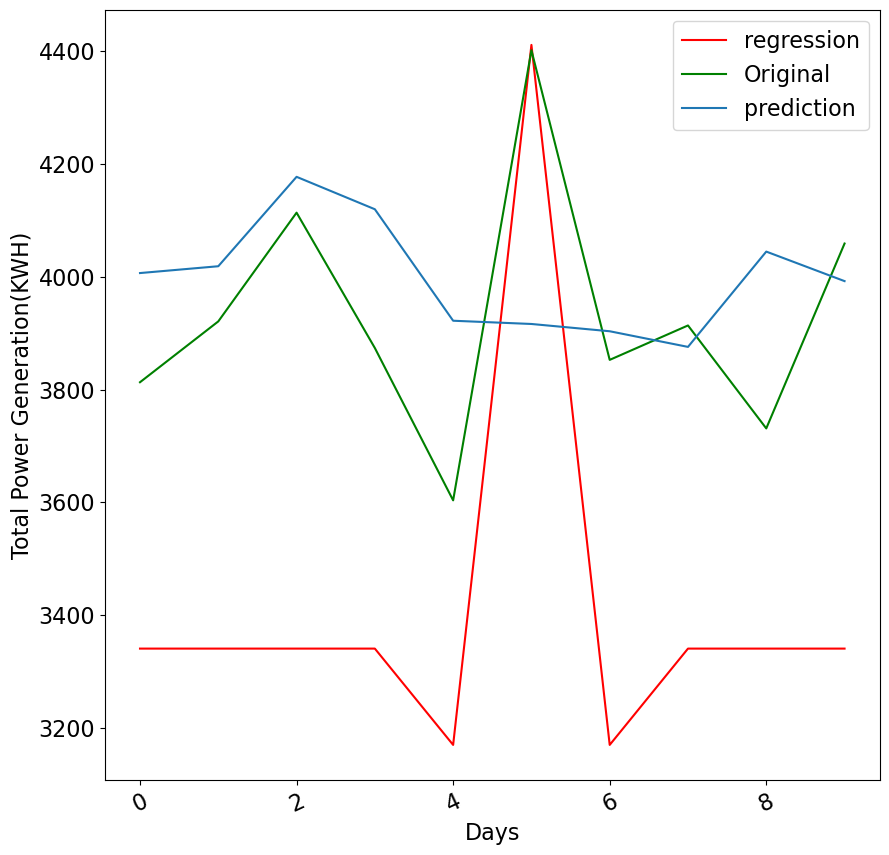

In [159]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, Y_predrand, c="r", label="regression")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.75, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)
plt.show()

In [160]:
fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_regression', dpi=500)

## Thresholding

In [161]:
threshold_dict = dict()
threshold_dict['Grid_pred'] = 0.4
threshold_dict['Module_pred'] = 0.85
threshold_dict['Cloudy_pred'] = 0.1
threshold_dict['Inverter_pred'] = 0.3


In [162]:
new_X_test = pd.DataFrame(columns=X_test.columns)

In [163]:
# new_X_test['Insolation_pred'] = X_test['Insolation_pred']
# new_X_test['NO-OFF-CLEAN MODULES'] = X_test['NO-OFF-CLEAN MODULES']

In [164]:
for index, row in X_test.iterrows():
    for key in threshold_dict.keys():
        if key in X_test.columns:
            if row[key] >= threshold_dict[key]:
                new_X_test.loc[index, key] = 1
            else:
                new_X_test.loc[index, key] = 0

In [165]:
new_X_test

,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,0,1,0,0
4,1,1,0,0
5,0,0,0,0
6,1,1,0,0
7,1,0,0,0
8,0,0,0,0
9,0,1,0,0


In [166]:
Y_predrand_thr = regr.predict(new_X_test)
print(mean_squared_error(Y_test, Y_predrand_thr)**(1/2))

617.4311786741994


c:\Users\Rajeshsingh\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Cloudy_pred
- Grid_pred
- Inverter_pred
- Module_pred
Feature names seen at fit time, yet now missing:
- Cloudy
- Grid Failure
- Inverter
- Module Cleaning

  warnings.warn(message, FutureWarning)


In [167]:
rmspe = round(np.sqrt(np.mean(np.square(((Y_test - Y_predrand_thr) / Y_test)), axis=0))*100,3)
rmspe

15.777

In [168]:
pd.set_option("display.max_columns", None)

In [169]:
all_data_of_2019 = df_obj['2019'][:forecast_days]

In [170]:
all_data_of_2019

,Date,1104500527,1104500529,1.104501e+09,7802195.0,2100570073/ 2100567820/ 2100567898,Total Generation (KWH),Aggregate Meter Reading (KWH),Difference,SEEDs data (KWH),Insolation,PR (%),Any Issues/Problems Observed,WO#,NO-OFF-CLEAN MODULES,Grid Failure,Inverter,Module Cleaning,Rainy day,No Module Cleaning,Transformer replacement and maintenance,Cable and Fuse maintenance,Plant Shutdown,Internet,Battery,Cloudy,Module Cleaning by rains
0,2019-01-01,814.0,990.0,947.0,1024.0,37.94,3812.94,3658.50,154.44,3816.0,5.357,0.694288,"Grid Failure From-15:49 to 15:56, Module Clean...",NaN,524.0,1,0,1,0,0,0,0,0,0,0,0,0
1,2019-01-02,809.0,1023.0,988.0,1063.0,37.74,3920.74,3779.25,141.49,3924.0,5.380,0.710885,"Today morning time Inverter No :-4 ,ABB 250KW ...",NaN,441.0,1,0,1,0,0,0,0,0,0,0,0,0
2,2019-01-03,859.0,1046.0,1049.0,1119.0,40.45,4113.45,3995.25,118.20,4117.0,5.598,0.716804,"Grid Failure From-17:19 to 17:20, Module Clean...",NaN,903.0,1,0,1,0,0,0,0,0,0,0,0,0
3,2019-01-04,803.0,1006.0,978.0,1048.0,38.59,3873.59,3717.75,155.84,3877.0,5.136,0.735738,"Module Cleaning has been done in Row-G,H,I,J,K...",NaN,1281.0,0,0,1,0,0,0,0,0,0,0,0,0
4,2019-01-05,775.0,944.0,907.0,943.0,34.61,3603.61,3465.00,138.61,3607.0,4.808,0.731197,"Module Cleaning has been done in Row-A,B,C,D,E...",NaN,792.0,0,0,1,0,0,0,0,0,0,0,0,0
5,2019-01-06,944.0,1153.0,1109.0,1154.0,41.37,4401.37,4240.50,160.87,4405.0,5.946,0.722061,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0
6,2019-01-07,842.0,1007.0,972.0,993.0,38.56,3852.56,3697.50,155.06,3860.0,5.184,0.72573,"Module Cleaning has been done in Row-C,D,E,F ...",NaN,630.0,0,0,1,0,0,0,0,0,0,0,0,0
7,2019-01-08,842.0,1017.0,978.0,1038.0,38.55,3913.55,3768.00,145.55,3920.0,5.260,0.726362,"Module Cleaning has been done in Row-,G,H,I,J,...",NaN,936.0,0,0,1,0,0,0,0,0,0,0,0,0
8,2019-01-09,798.0,955.0,928.0,1013.0,37.08,3731.08,3588.75,142.33,3735.0,5.008,0.726907,"Grid Failure From-12:28 to 12:35, Module Clean...",NaN,816.0,1,0,1,0,0,0,0,0,0,0,0,0
9,2019-01-10,847.0,1035.0,1033.0,1104.0,39.75,4058.75,3912.00,146.75,4062.0,5.336,0.741954,"Module Cleaning has been done in Row-K,L,M,N, ...",NaN,987.0,0,0,1,0,0,0,0,0,0,0,0,0


In [171]:
#df_obj['2019'][]

In [172]:
new_X_test

,Grid_pred,Module_pred,Cloudy_pred,Inverter_pred
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,0,1,0,0
4,1,1,0,0
5,0,0,0,0
6,1,1,0,0
7,1,0,0,0
8,0,0,0,0
9,0,1,0,0


In [173]:
rmspe = round(np.sqrt(np.mean(np.square(((Y_test - Y_predrand_thr) / Y_test)), axis=0))*100,3)
rmspe

15.777

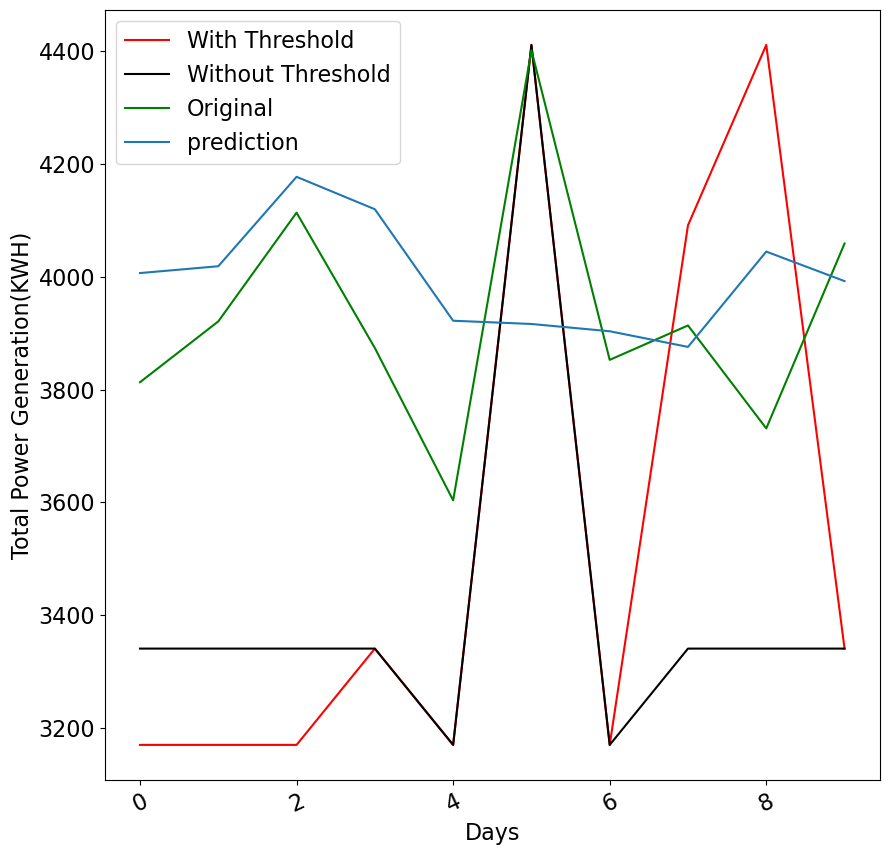

In [174]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, Y_predrand_thr, c="r", label="With Threshold")
plt.plot(count, Y_predrand, c="black", label="Without Threshold")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.15, .75, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)
plt.show()

In [175]:
fig.savefig("result/"+str(forecast_days)+'_Days Prediction_for_threshold_without_threshold_regression', dpi=500)

## XG Boost

In [176]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [177]:
# Instantiation
import xgboost as xg

In [178]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
 
# Fitting the model
xgb_r.fit(X_train, Y_train)

[18:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [179]:
check_x_test = new_X_test.to_numpy()

In [180]:
check_x_test

array([[1, 1, 0, 0],
       [1, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 0, 0]], dtype=object)

In [181]:
# Predict the model
pred = xgb_r.predict(check_x_test)

In [182]:
pred

array([3100.2078, 3100.2078, 3100.2078, 3251.6072, 3100.2078, 4280.8726,
       3100.2078, 3964.8018, 4280.8726, 3251.6072], dtype=float32)

In [183]:
# RMSE Computation
rmse = round(np.sqrt(np.mean(np.square(((Y_test - pred) / Y_test)), axis=0))*100,3)
print("RMSPE : % f" %(rmse))

RMSPE :  16.883000


In [184]:
clf = GridSearchCV(xgb_r,parameters)
clf.fit(X_train,Y_train)
y_pred = clf.predict(check_x_test)

[18:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:10] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [185]:
# RMSE Computation
rmse = round(np.sqrt(np.mean(np.square(((Y_test - y_pred) / Y_test)), axis=0))*100,3)
print("RMSPE : % f" %(rmse))

RMSPE :  14.963000


In [186]:
fig = plt.figure(figsize=(10,10))

plt.plot(count, pred, c="r", label="With XGBoost")
# plt.plot(count, Y_predrand, c="black", label="Without Threshold")
plt.plot(count, Y_test, c="g", label='Original')
plt.plot(count, diff_power['Prediction'], label='prediction')
# plt.figtext(.15, .75, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.xticks(rotation=25)l
plt.grid()
plt.show()

SyntaxError: invalid syntax (1466004530.py, line 11)

## new pattern wise scatter plot

In [ ]:
previous_power = df_obj['2018']['Total Generation (KWH)'][-lag:]

In [ ]:
diff_power['Prediction']

0    4006.415791
1    4018.499292
2    4176.960999
3    4119.503935
4    3921.924689
5    3916.175485
6    3903.286758
7    3875.556369
8    4044.455014
9    3992.133402
Name: Prediction, dtype: float64

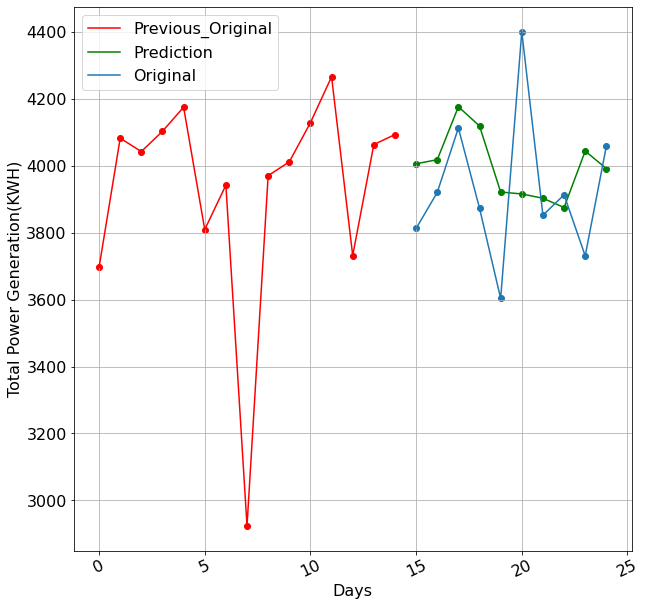

In [ ]:
fig = plt.figure(figsize=(10,10))
font = {'size': 16}
plt.rc('font', **font)
range1 = range(len(previous_power))
range2 = range(len(previous_power), len(previous_power)+len(diff_power['Prediction']))
plt.scatter(range1, previous_power, c="r")
plt.plot(range1, previous_power, c="r", label="Previous_Original")
plt.scatter(range2, diff_power['Prediction'], c="g")
plt.plot(range2, diff_power['Prediction'], c="g", label="Prediction")
# plt.scatter('Date', 'Prediction', data=diff_power, label='Prediction', c='r')
plt.scatter(range2, diff_power['Original'])
plt.plot(range2, diff_power['Original'], label='Original')
plt.legend()
# plt.figtext(.68, .25, "RMSPE="+str(round(rmspe, 3))+"%", c='g')
# plt.figtext(.68, .2, "RMSE="+str(round(rmse, 3)), c='g')
# plt.figtext(.68, .15, "MAE="+str(round(mae, 3)), c='g')
plt.xticks(rotation=25)
plt.grid()
plt.xlabel("Days")
plt.ylabel("Total Power Generation(KWH)")
plt.show()
# plt.title(str(forecast_days)+'_Days Prediction_for_Binary_Var', fontsize=30)

In [ ]:
#spider graph/chart

## Arima

In [ ]:
import statsmodels as sm
from statsmodels.tsa.vector_ar.var_model import 

SyntaxError: invalid syntax (576078763.py, line 2)

In [ ]:
mod = sm.tsa.VARMAX()
# endog, order = (1, 0, 0))

In [ ]:
res_default_timeseries = sm.tsa.vector_ar.var_model.TimeSeriesModel(endog_array)

In [ ]:
res_default_timeseries.predict(df1[:forecast_days])